In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

columns = ['user_id', 'movie_id', 'rating', 'timestamp']
df = pd.read_csv('../data/ml-100k/u.data', sep='\t', names=columns)
print(df.shape)
print(df.head())
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

n_users = df['user_id'].nunique()
n_items = df['movie_id'].nunique()
print(f'Number of users: {n_users}')
print(f'Number of items: {n_items}')
print(f'Train set size: {train_df.shape}')
print(f'Test set size: {test_df.shape}')

(100000, 4)
   user_id  movie_id  rating  timestamp
0      196       242       3  881250949
1      186       302       3  891717742
2       22       377       1  878887116
3      244        51       2  880606923
4      166       346       1  886397596
Number of users: 943
Number of items: 1682
Train set size: (80000, 4)
Test set size: (20000, 4)


In [22]:
class MatrixFactorization:
    def __init__(self, n_users, n_items, n_factors=20, learning_rate=0.01, regularization=0.02, n_epochs=20, verbose=True):
        self.n_users = n_users
        self.n_items = n_items
        self.n_factors = n_factors
        self.lr = learning_rate
        self.reg = regularization
        self.n_epochs = n_epochs
        self.verbose = verbose

        # Khởi tạo các ma trận P, Q và các bias
        # np.random.normal để khởi tạo giá trị gần 0
        self.P = np.random.normal(scale=1./self.n_factors, size=(n_users, n_factors))
        self.Q = np.random.normal(scale=1./self.n_factors, size=(n_items, n_factors))
        self.user_bias = np.zeros(n_users)
        self.item_bias = np.zeros(n_items)
        self.global_bias = 0

    def fit(self, train_data, test_data=None):
        """
        Huấn luyện mô hình sử dụng SGD.
        
        Args:
            train_data (pd.DataFrame): Dữ liệu huấn luyện, có các cột ['userId', 'itemId', 'rating'].
            test_data (pd.DataFrame, optional): Dữ liệu kiểm tra để theo dõi lỗi.
        """
        # Ánh xạ ID thực tế sang index của ma trận (0, 1, 2...)
        self.user_map = {id: i for i, id in enumerate(train_data['user_id'].unique())}
        self.item_map = {id: i for i, id in enumerate(train_data['movie_id'].unique())}
        self.rev_user_map = {i: id for id, i in self.user_map.items()}
        self.rev_item_map = {i: id for id, i in self.item_map.items()}
        
        # Tính bias toàn cục
        self.global_bias = train_data['rating'].mean()
        
        # Chuyển đổi dữ liệu huấn luyện thành mảng numpy để truy cập nhanh hơn
        training_samples = train_data[['user_id', 'movie_id', 'rating']].values
        
        history = {'train_rmse': [], 'test_rmse': []}
        
        for epoch in range(self.n_epochs):
            # Xáo trộn dữ liệu ở mỗi epoch để tránh các thứ tự tuần hoàn
            np.random.shuffle(training_samples)
            
            # Lặp qua từng rating
            for user_id, item_id, rating in training_samples:
                u = self.user_map[user_id]
                i = self.item_map[item_id]
                
                # Dự đoán
                prediction = self.predict_single(u, i)
                
                # Tính lỗi
                error = rating - prediction
                
                # Cập nhật bias
                self.user_bias[u] += self.lr * (error - self.reg * self.user_bias[u])
                self.item_bias[i] += self.lr * (error - self.reg * self.item_bias[i])
                
                # Cập nhật ma trận P và Q
                P_u_old = self.P[u, :]
                self.P[u, :] += self.lr * (error * self.Q[i, :] - self.reg * self.P[u, :])
                self.Q[i, :] += self.lr * (error * P_u_old - self.reg * self.Q[i, :])

            # Tính toán và lưu lại lỗi sau mỗi epoch
            train_rmse = self.evaluate(train_data)
            history['train_rmse'].append(train_rmse)
            
            if test_data is not None:
                test_rmse = self.evaluate(test_data)
                history['test_rmse'].append(test_rmse)
                if self.verbose:
                    print(f"Epoch {epoch+1}/{self.n_epochs} - Train RMSE: {train_rmse:.4f} - Test RMSE: {test_rmse:.4f}")
            else:
                if self.verbose:
                    print(f"Epoch {epoch+1}/{self.n_epochs} - Train RMSE: {train_rmse:.4f}")
                    
        return history

    def predict_single(self, user_idx, item_idx):
        """Dự đoán rating cho một cặp (user_index, item_index)."""
        prediction = self.global_bias + self.user_bias[user_idx] + self.item_bias[item_idx]
        prediction += self.P[user_idx, :].dot(self.Q[item_idx, :].T)
        return prediction

    def predict(self, data):
        """Dự đoán rating cho một DataFrame."""
        predictions = []
        for _, row in data.iterrows():
            user_id, item_id = row['user_id'], row['movie_id']
            
            # Xử lý Cold Start: nếu user/item không có trong tập train
            if user_id not in self.user_map or item_id not in self.item_map:
                predictions.append(self.global_bias) # Fallback về trung bình toàn cục
                continue
            
            u = self.user_map[user_id]
            i = self.item_map[item_id]
            predictions.append(self.predict_single(u, i))
        return predictions

    def evaluate(self, data):
        """Tính RMSE trên một tập dữ liệu."""
        y_true = data['rating'].values
        y_pred = self.predict(data)
        return np.sqrt(mean_squared_error(y_true, y_pred))

In [23]:
# Lấy số lượng user và item từ TOÀN BỘ dữ liệu để đảm bảo ma trận có đủ kích thước
# (Mặc dù mapping chỉ được tạo trên tập train)
n_users_total = df['user_id'].max() + 1 # +1 vì index bắt đầu từ 0
n_items_total = df['movie_id'].max() + 1

# Khởi tạo mô hình
mf_model = MatrixFactorization(
    n_users=n_users_total, 
    n_items=n_items_total, 
    n_factors=50,         # Số lượng đặc trưng ẩn
    learning_rate=0.01,
    regularization=0.02,
    n_epochs=25
)

# Huấn luyện mô hình
history = mf_model.fit(train_df, test_df)

Epoch 1/25 - Train RMSE: 0.9666 - Test RMSE: 0.9774
Epoch 2/25 - Train RMSE: 0.9427 - Test RMSE: 0.9580
Epoch 3/25 - Train RMSE: 0.9322 - Test RMSE: 0.9510
Epoch 4/25 - Train RMSE: 0.9258 - Test RMSE: 0.9468
Epoch 5/25 - Train RMSE: 0.9215 - Test RMSE: 0.9438
Epoch 6/25 - Train RMSE: 0.9181 - Test RMSE: 0.9431
Epoch 7/25 - Train RMSE: 0.9150 - Test RMSE: 0.9424
Epoch 8/25 - Train RMSE: 0.9115 - Test RMSE: 0.9409
Epoch 9/25 - Train RMSE: 0.9073 - Test RMSE: 0.9390
Epoch 10/25 - Train RMSE: 0.9015 - Test RMSE: 0.9377
Epoch 11/25 - Train RMSE: 0.8936 - Test RMSE: 0.9353
Epoch 12/25 - Train RMSE: 0.8832 - Test RMSE: 0.9321
Epoch 13/25 - Train RMSE: 0.8708 - Test RMSE: 0.9294
Epoch 14/25 - Train RMSE: 0.8570 - Test RMSE: 0.9258
Epoch 15/25 - Train RMSE: 0.8416 - Test RMSE: 0.9227
Epoch 16/25 - Train RMSE: 0.8246 - Test RMSE: 0.9205
Epoch 17/25 - Train RMSE: 0.8060 - Test RMSE: 0.9184
Epoch 18/25 - Train RMSE: 0.7858 - Test RMSE: 0.9167
Epoch 19/25 - Train RMSE: 0.7649 - Test RMSE: 0.9157
Ep

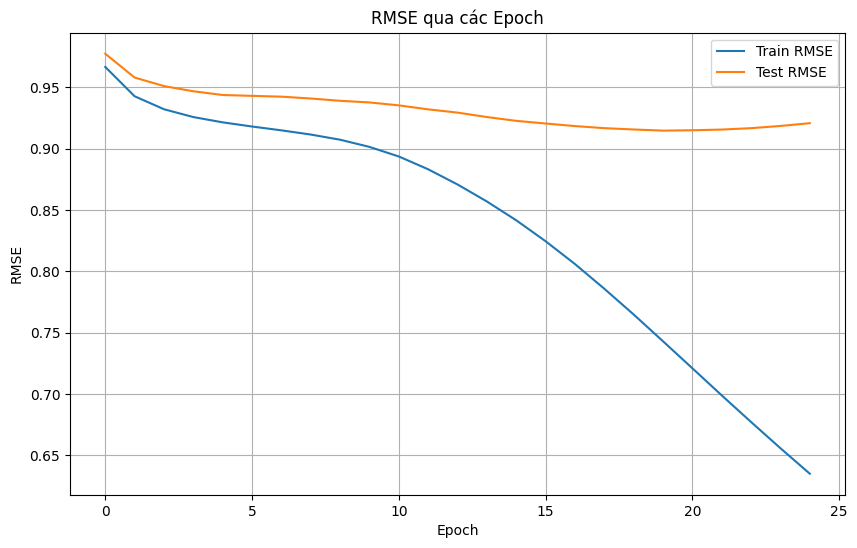

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history['train_rmse'], label='Train RMSE')
plt.plot(history['test_rmse'], label='Test RMSE')
plt.title('RMSE qua các Epoch')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()